# Unified MDTF/GFDL/NCAR Analysis Notebook Template

More details on the development process:
[MDTF Planning Document](https://docs.google.com/document/d/1P8HqL8O5304qwR3ik9RmgFDwSWwlkPgOjnp39PIkLfY/edit?usp=sharing)

In [1]:
# Development mode: constantly refreshes module code
%load_ext autoreload
%autoreload 2

## Framework Code and Diagnostic Setup

In [2]:
from esnb import NotebookDiagnostic, RequestedVariable, CaseGroup

In [3]:
%%time

# Define a mode (leave "prod" for now)
mode = "prod"

# Verbosity
verbose = True

# Give your diagnostic a name and a short description
diag_name = "Example Notebook-based Diagnostic"
diag_desc = "This example demonstrates how to use the notebook template"

# Define what variables you would like to analyze. The first entry is the
# variable name and the second entry is the realm (post-processing dir).
#   (By default, monthly timeseries data will be loaded. TODO: add documentation
#    on how to select different frequencies, multiple realms to search, etc.)
variables = [
    RequestedVariable("tauctpmodis_1", "atmos_modis"),
    RequestedVariable("tauctpmodis_2", "atmos_modis"),
    RequestedVariable("tauctpmodis_3", "atmos_modis"),
    RequestedVariable("tauctpmodis_4", "atmos_modis"),
    RequestedVariable("tauctpmodis_5", "atmos_modis"),
    RequestedVariable("tauctpmodis_6", "atmos_modis"),
    RequestedVariable("tauctpmodis_7", "atmos_modis"),
    RequestedVariable("ctpmodis", "atmos_modis"),
    RequestedVariable("lwpmodis", "atmos_modis"),
    RequestedVariable("iwpmodis", "atmos_modis"),
    RequestedVariable("locldmodis", "atmos_modis"),
    RequestedVariable("hicldmodis", "atmos_modis"),
    RequestedVariable("mdcldmodis", "atmos_modis"),
    RequestedVariable("lremodis", "atmos_modis"),
    RequestedVariable("iremodis", "atmos_modis"),

    RequestedVariable("IWP", "atmos"),
    RequestedVariable("LWP", "atmos"),
    RequestedVariable("low_cld_amt", "atmos"),
    RequestedVariable("high_cld_amt", "atmos"),
    RequestedVariable("mid_cld_amt", "atmos"),
]

# Initialize the diagnostic with its name, description, vars, and options
diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables)

# Define the groups of experiments to analyze. Provide a single dora id for one experiment
# or a list of IDs to aggregate multiple experiments into one; e.g. historical+future runs
# dora id: cm5-9
groups = [
    CaseGroup("am5dt-391", date_range=("1980-01-01", "1985-12-31"), verbose=verbose),
]

# Combine the experiments with the diag request and determine what files need to be loaded:
diag.resolve(groups)

am5dt-391: Fetching metadata from Dora
am5dt-391: Loading intake catalog from Dora
Resolving required vars for c96L65_am5f8d6r3_amip_cosp
CPU times: user 4.99 s, sys: 72.7 ms, total: 5.06 s
Wall time: 5.19 s


<i>(The files above are necessary to run the diagnostic.)</i>

In [4]:
# Dmget the necessary files
diag.dmget()

# Load the data as xarray datasets
diag.load()

# Put all of the xarray datasets into a list
dsets = diag.dsets

dmget: All files are online


In [5]:
print(groups)

[CaseGroup <c96L65_am5f8d6r3_amip_cosp>  n_sources=1  resolved=True  loaded=True
  * CaseExperiment c96L65_am5f8d6r3_amip_cosp: catalog=True date_range=['1980-01-01', '1985-12-31']]


In [6]:
import xarray as xr
root = '/archive/Huan.Guo/work/obs/CFMIP-OBS/MODIS/MCD06COSP_D3_MODIS/'
#fname = f'{root}/MCD06COSP_D3_MODIS_2008_Ann.nc'
fname = f'{root}/MCD06COSP_D3_MODIS_2002To2023_Ann.nc'

MODIS_grps = xr.open_dataset(fname)
for group in MODIS_grps:
    print(group)

MODIS_tau_grp = xr.open_dataset(fname, group='Cloud_Optical_Thickness_Total')

from netCDF4 import Dataset

def explore_netcdf_groups(nc_file):
    def walk_group(group, indent=0):
        prefix = "  " * indent
        print(f"{prefix}Group: {group.path}")

        # List dimensions
        if group.dimensions:
            print(f"{prefix}  Dimensions:")
            for name, dim in group.dimensions.items():
                print(f"{prefix}    {name}: size={len(dim)}, unlimited={dim.isunlimited()}")

        # List variables
        if group.variables:
            print(f"{prefix}  Variables:")
            for name, var in group.variables.items():
                dims = ", ".join(var.dimensions)
                print(f"{prefix}    {name} ({dims}) -> dtype: {var.dtype}")

        # Recurse into subgroups
        for subgrp in group.groups.values():
            walk_group(subgrp, indent + 1)

# Provide your file path here
explore_netcdf_groups(fname)


In [7]:
vars = ["LWP", "lwpmodis","IWP","iwpmodis","low_cld_amt",'locldmodis',"high_cld_amt",'hicldmodis', "mid_cld_amt",'mdcldmodis',
        'cldfrac', "ctpmodis",  "lremodis","iremodis",]
longnames = [
    "Liquid Water Path",
    "COSPMODIS Liquid Water Path",
    "Ice Water Path",
    "COSPMODIS Ice Water Path",
    "Low-Level Cloud Fraction",
    'COSPMODIS Low-Level Cloud Fraction',
    "High-Level Cloud Fraction",
    'COSPMODIS High-Level Cloud Fraction',
    "Mid-Level Cloud Fraction",
    'COSPMODIS Mid-Level Cloud Fraction',
    'COSPMODIS Total Cloud Fraction',
    "COSPMODIS Cloud Top Pressure",
    "COSPMODIS Liquid Effetcive Radius",
    "COSPMODIS Ice Effective Radius",
]

vars_plot = ["LWP", "IWP","low_cld_amt","high_cld_amt","mid_cld_amt"]
longnames_plot = [
    "Liquid Water Path",
    "Ice Water Path",
    "Low-Level Cloud Fraction",
    "High-Level Cloud Fraction",
    "Mid-Level Cloud Fraction",
]

In [8]:
# observation data regrid
from cosp_lib import cal_gbl_mean
import xesmf as xe
# load observations, to be added
cldfrac_obs_raw = MODIS_tau_grp['JHisto_vs_Cloud_Top_Pressure'] \
    .sum(dim=["jhisto_cloud_optical_thickness_total_7", "jhisto_cloud_top_pressure_7"]) \
    .squeeze()
for group in groups:
    target_grid = xr.Dataset({
        'lat': (['lat'], group.ds[0]['lat'].values),
        'lon': (['lon'], group.ds[0]['lon'].values),
    })
    regridder = xe.Regridder(cldfrac_obs_raw, target_grid, method='bilinear', periodic=True)
    group.ds[0]['cldfrac'] = group.ds[0]['tauctpmodis_1'] + group.ds[0]['tauctpmodis_2'] + group.ds[0]['tauctpmodis_3'] + group.ds[0]['tauctpmodis_4']+ group.ds[0]['tauctpmodis_5']+ group.ds[0]['tauctpmodis_6']+ group.ds[0]['tauctpmodis_7']
    group.ds[0]['cldfrac'] = group.ds[0]['cldfrac'].sum(dim='modistauindx').squeeze()
    group.ds[0]['cldfrac'].attrs['units'] = '%'
    group.ds[0]['cldfrac_obs'] = regridder(cldfrac_obs_raw)
    for var in vars:
        #group.ds[0][var] = group.ds[0][var] .where(group.ds[0][var] != 0)
        # Unit conversion
        units = group.ds[0][var].attrs.get("units", "")
        if units == "m":
            group.ds[0][var].values = group.ds[0][var].values * 1e6  # use 1e6, not 10^6
            group.ds[0][var].attrs["units"] = "micron"
        elif units == "Pa":
            group.ds[0][var].values = group.ds[0][var].values / 100.0
            group.ds[0][var].attrs["units"] = "hPa"

/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [9]:
import matplotlib.pyplot as plt
import cartopy.crs 
import numpy as np
from numpy import ma
%matplotlib inline

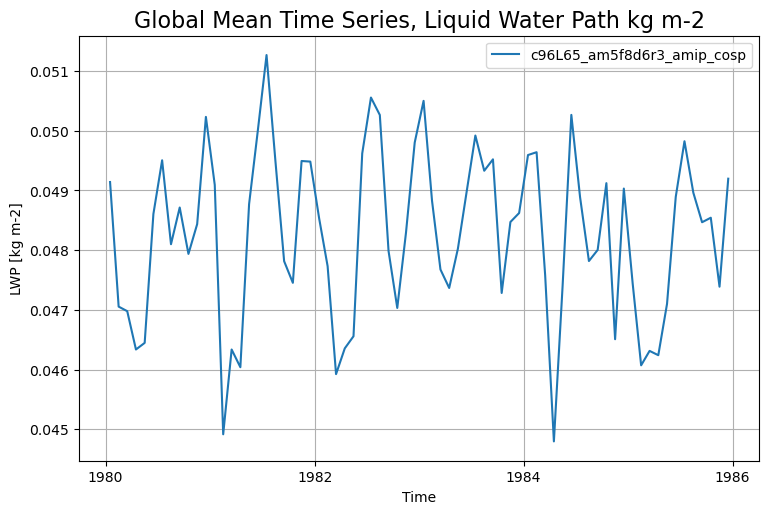

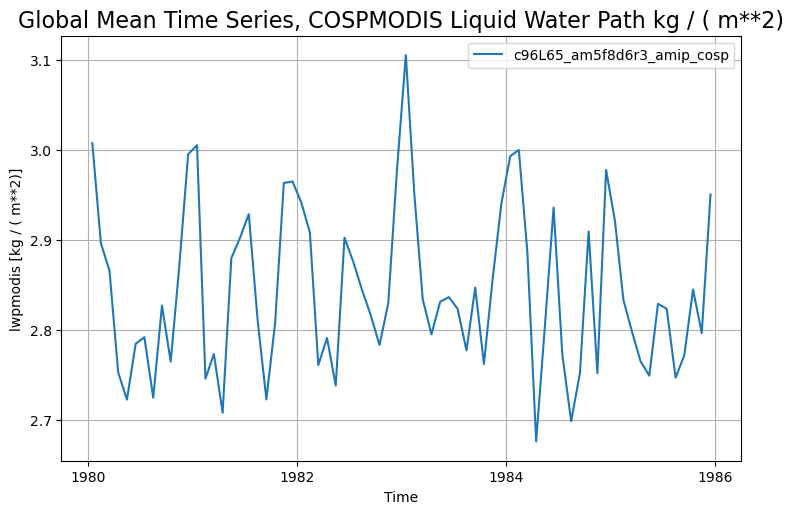

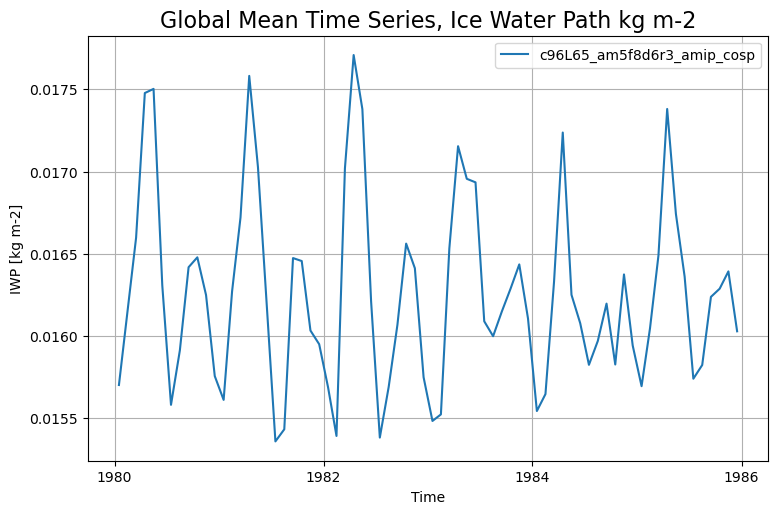

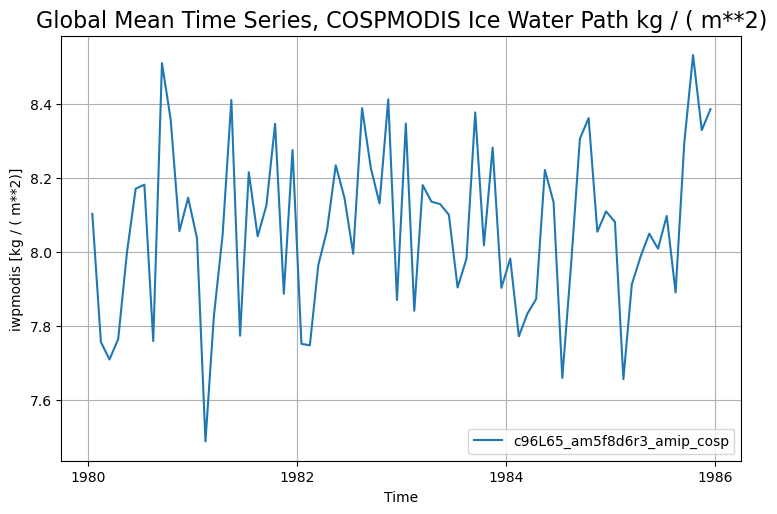

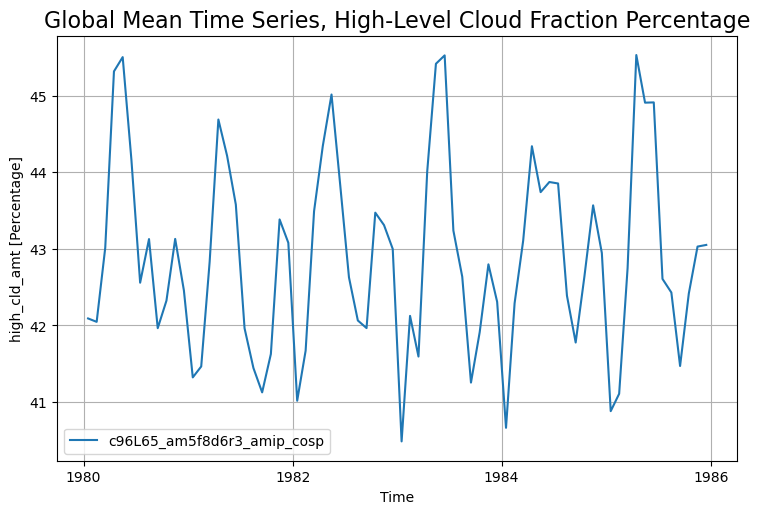

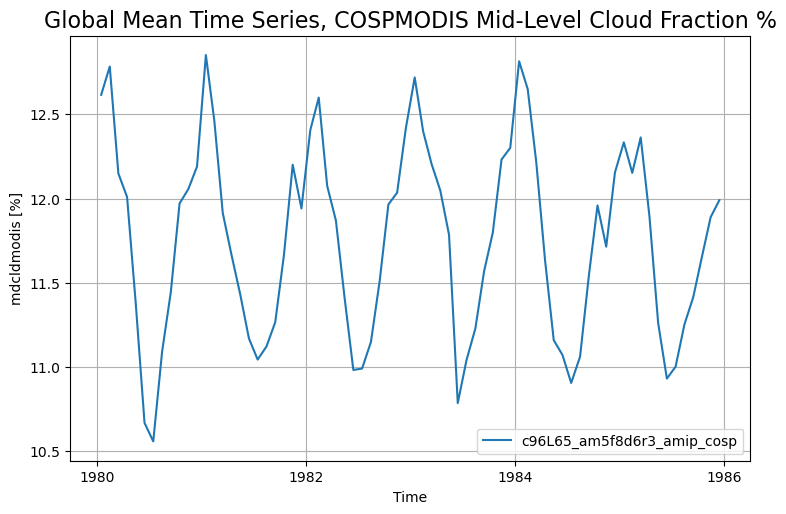

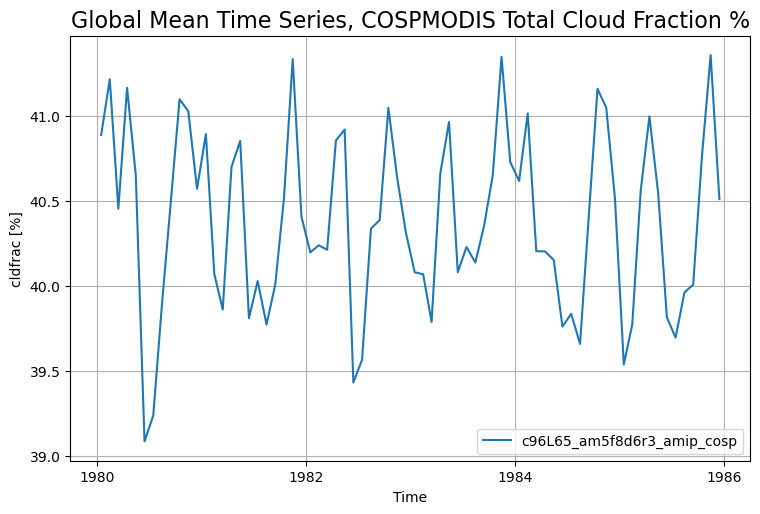

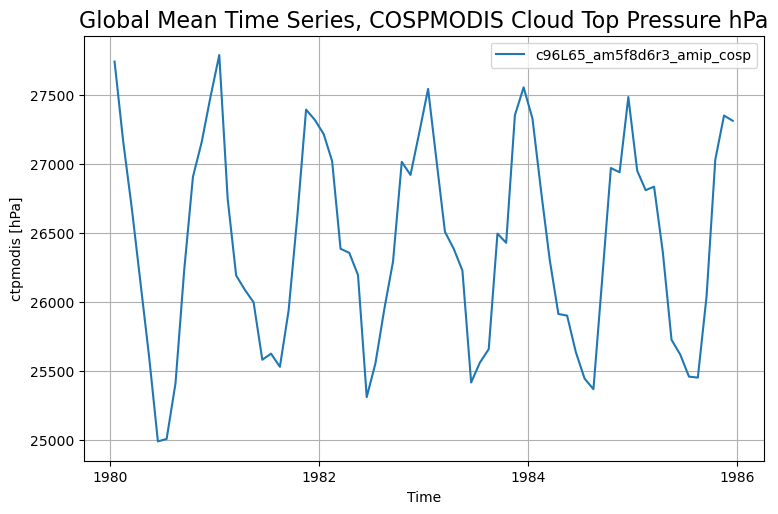

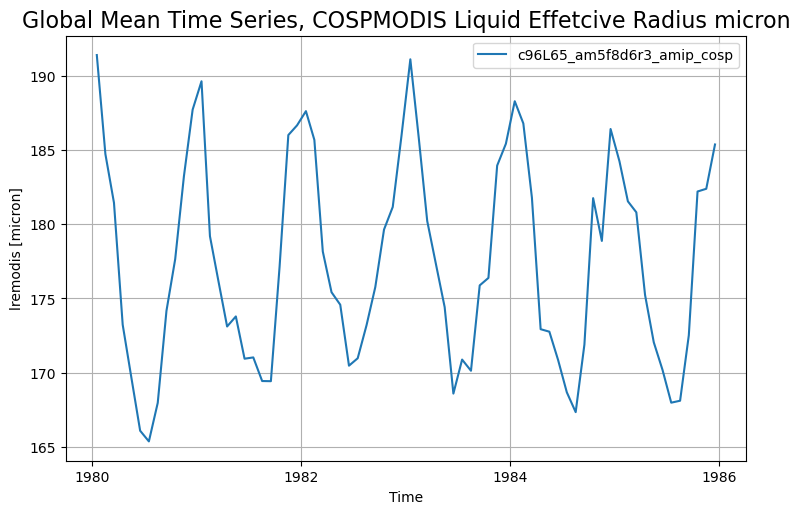

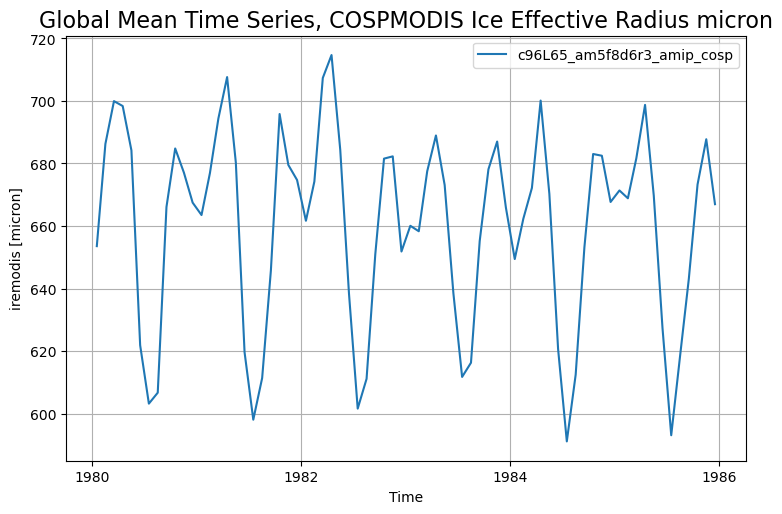

In [10]:
# global-mean time series
for var, longname in zip(vars, longnames):
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)

    for group in groups:
        ds = group.ds[0]
        gbl_mean_time = cal_gbl_mean(ds, var)
        ax.plot(ds['time'], gbl_mean_time, label=ds.title)

    ax.set_title(f"Global Mean Time Series, {longname} {groups[0].ds[0][var].units}", fontsize=16)
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{var} [{groups[0].ds[0][var].units}]")
    ax.legend()
    ax.grid(True)
    plt.show()



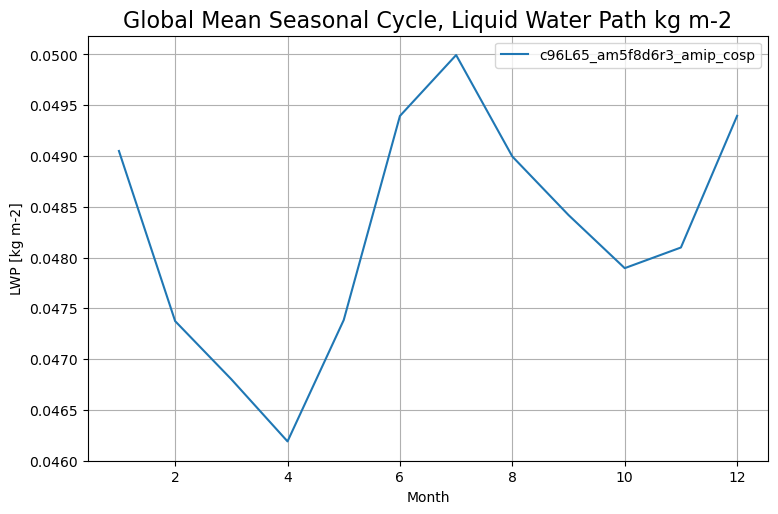

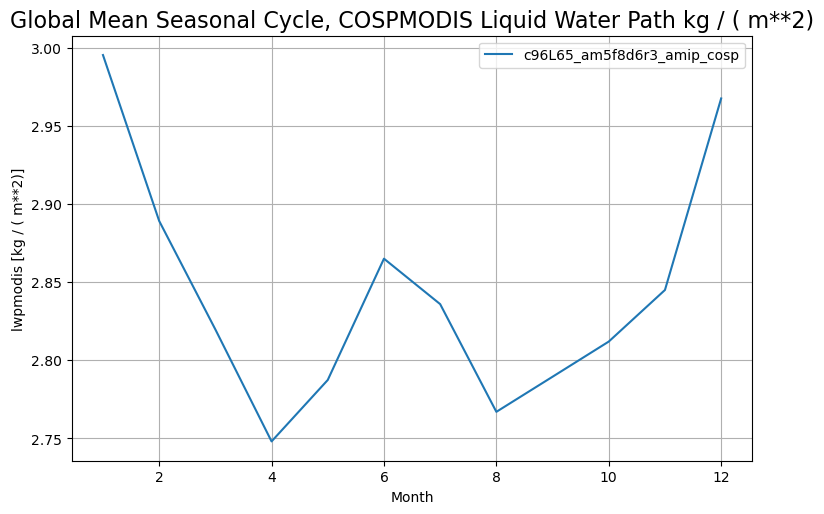

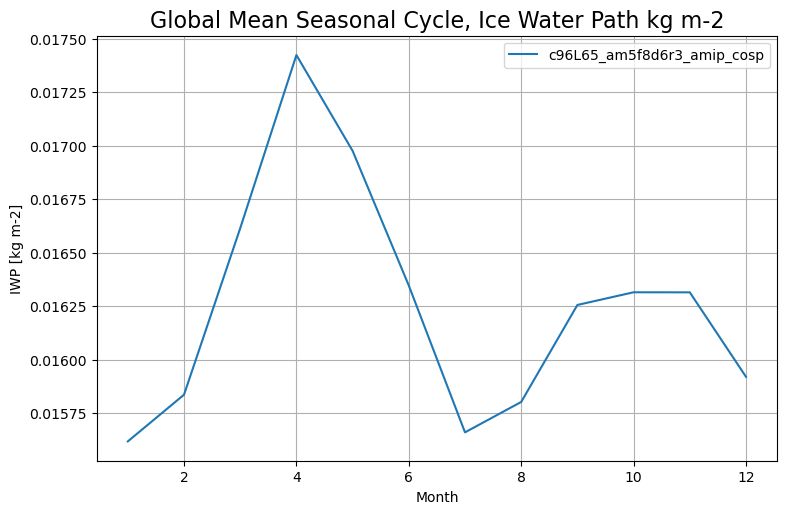

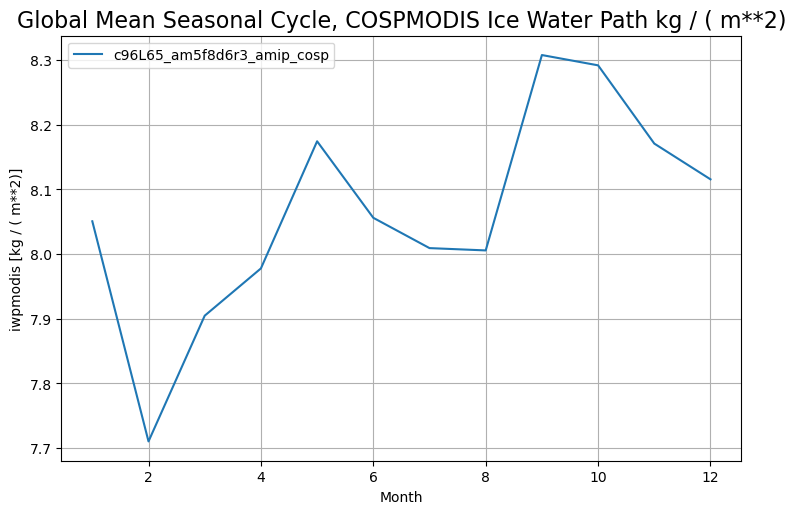

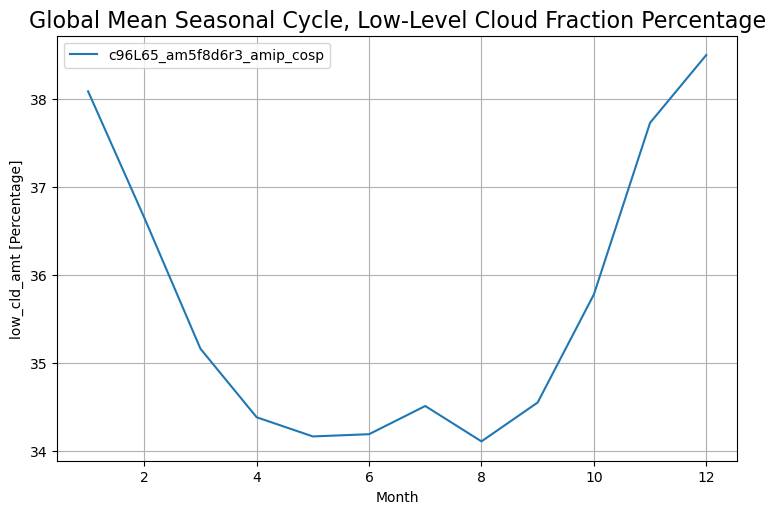

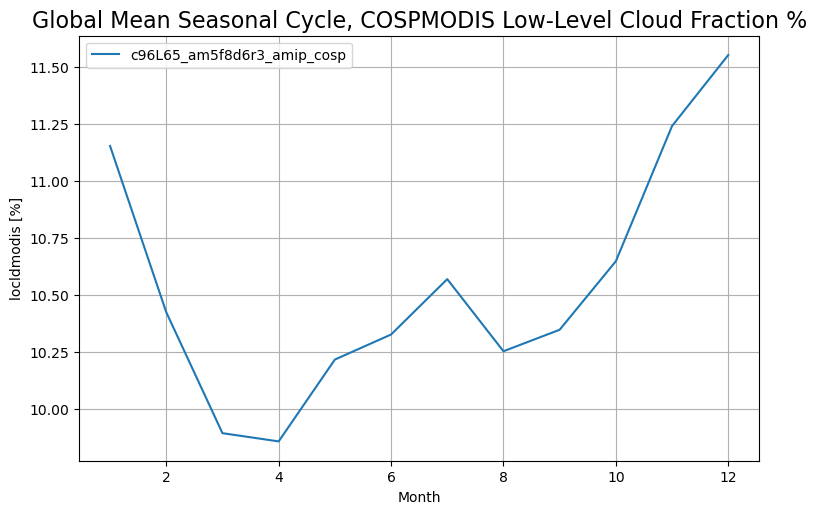

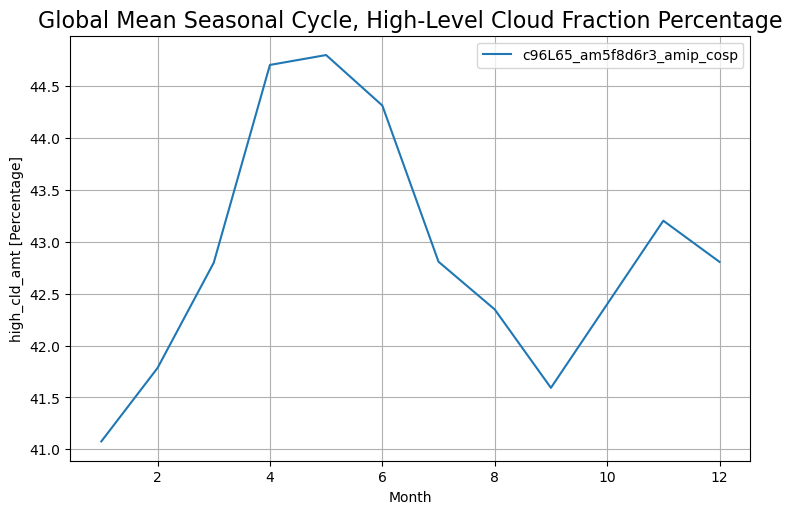

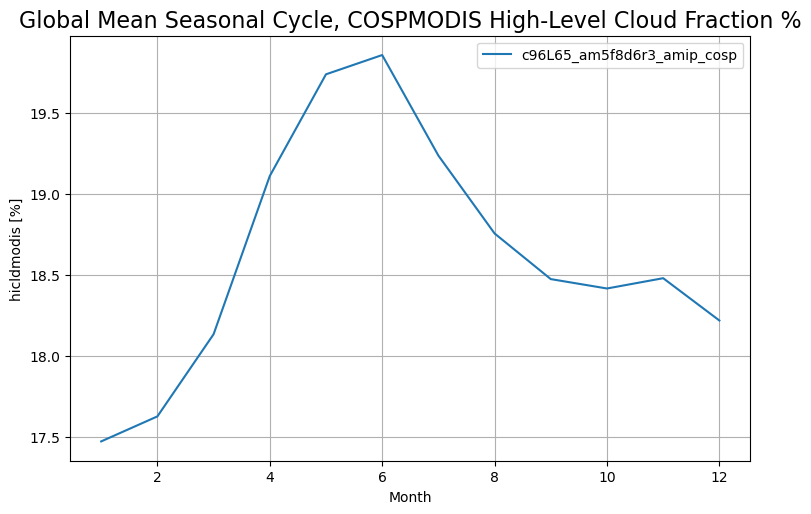

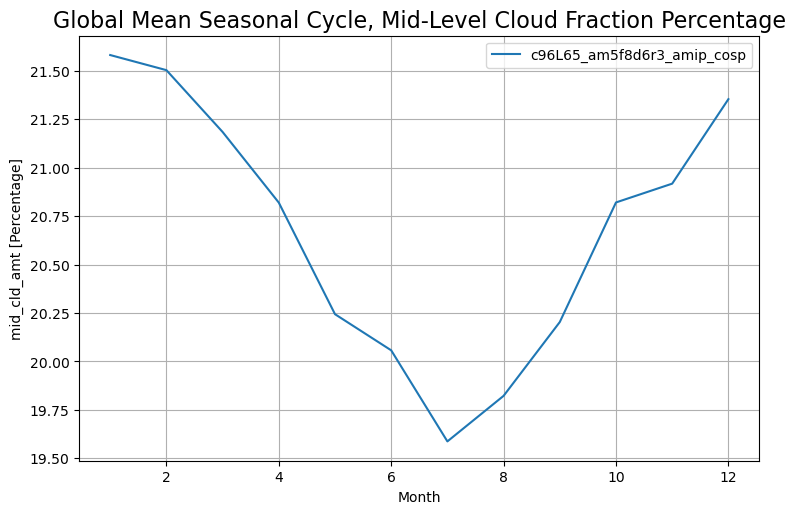

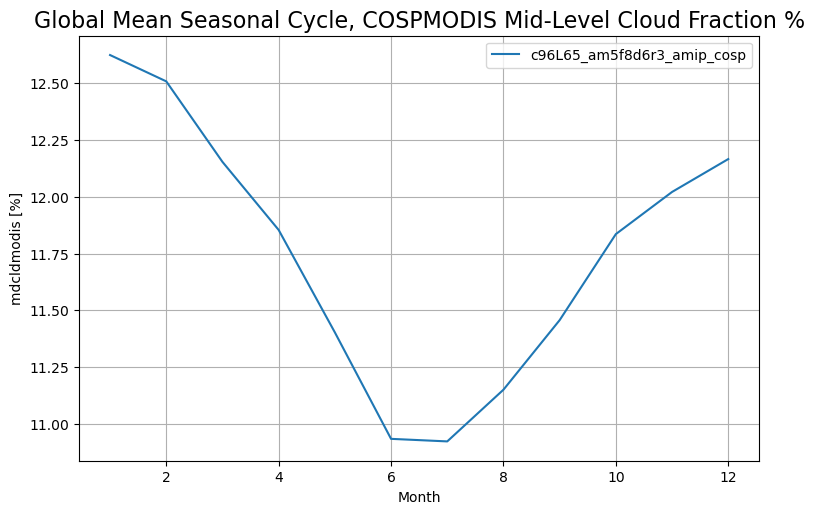

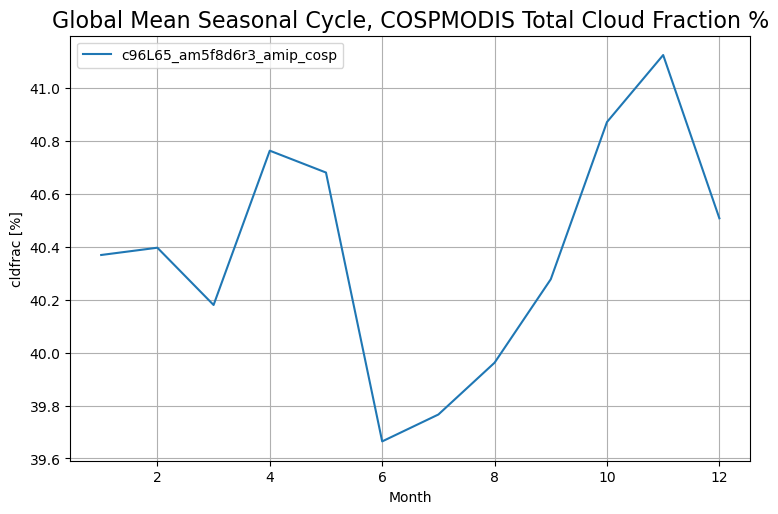

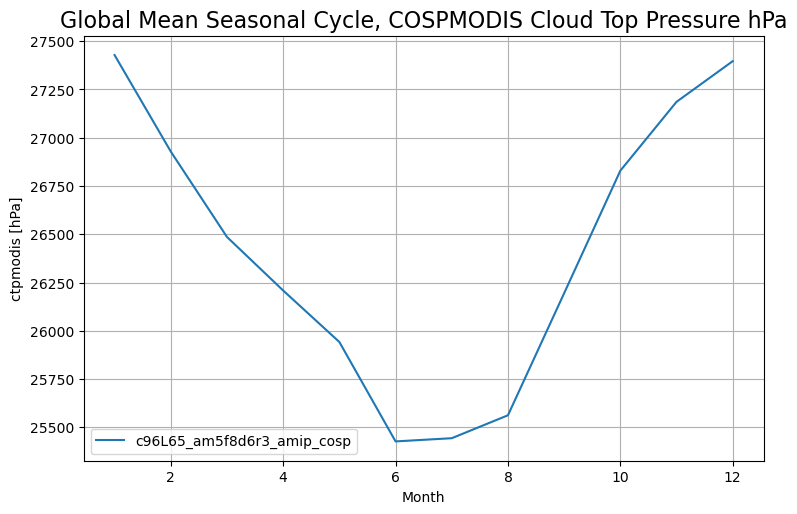

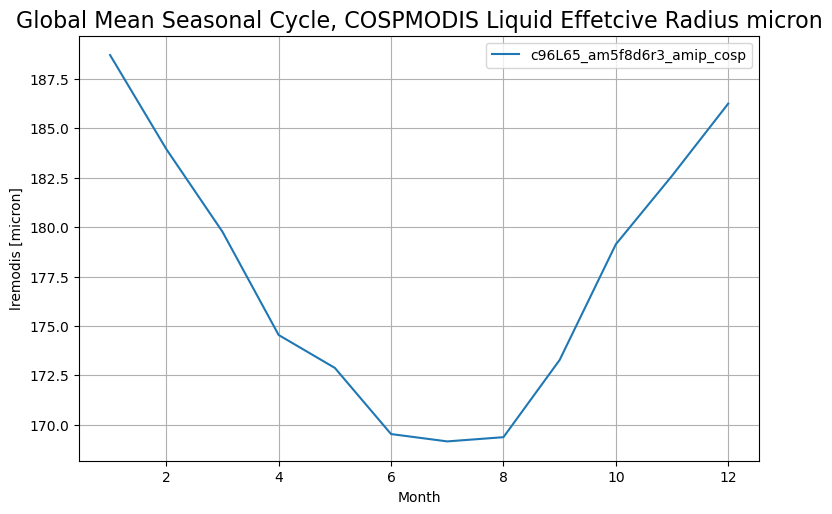

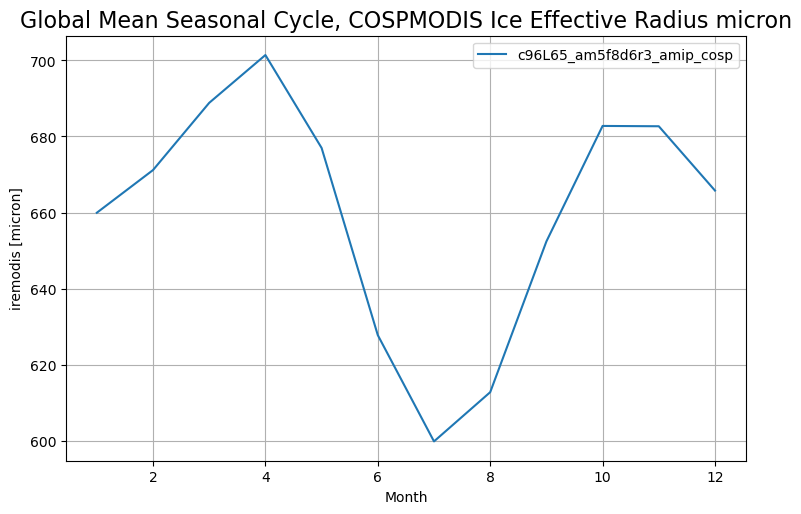

In [11]:
# global-mean seasonal cycle
from cosp_lib import cal_gbl_mean, monthly_mean
for var, longname in zip(vars, longnames):
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)

    for group in groups:
        ds = group.ds[0]
        monthly_clim = monthly_mean(ds, var)
        ax.plot(np.arange(1, 13), monthly_clim.values, label=ds.title)
        std_dev = monthly_clim.std(dim='month')
        group.add_metric(longname, ("seasonal std", float(std_dev)))

    ax.set_title(f"Global Mean Seasonal Cycle, {longname} {groups[0].ds[0][var].units}", fontsize=16)
    ax.set_xlabel("Month")
    ax.set_ylabel(f"{var} [{groups[0].ds[0][var].units}]")
    ax.legend()
    ax.grid(True)
    plt.show()



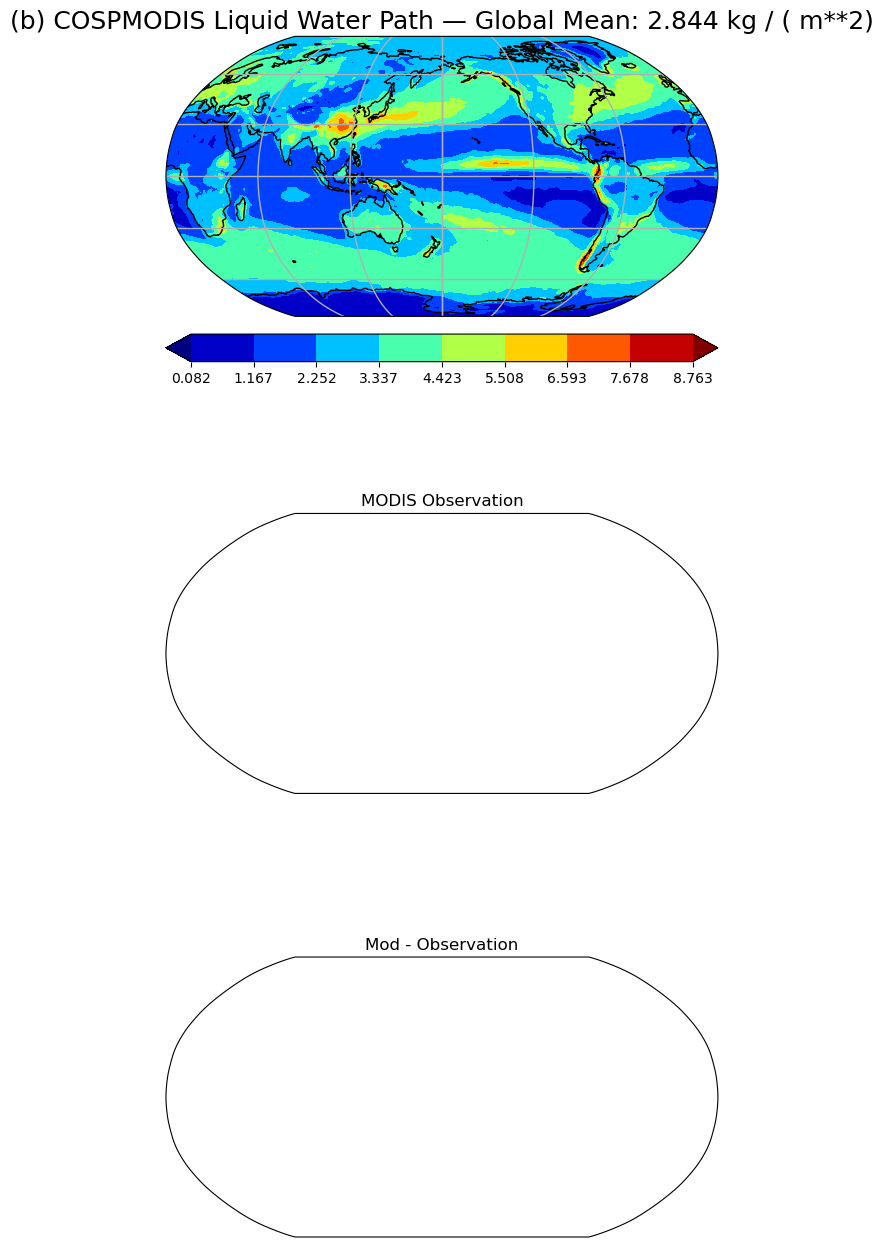

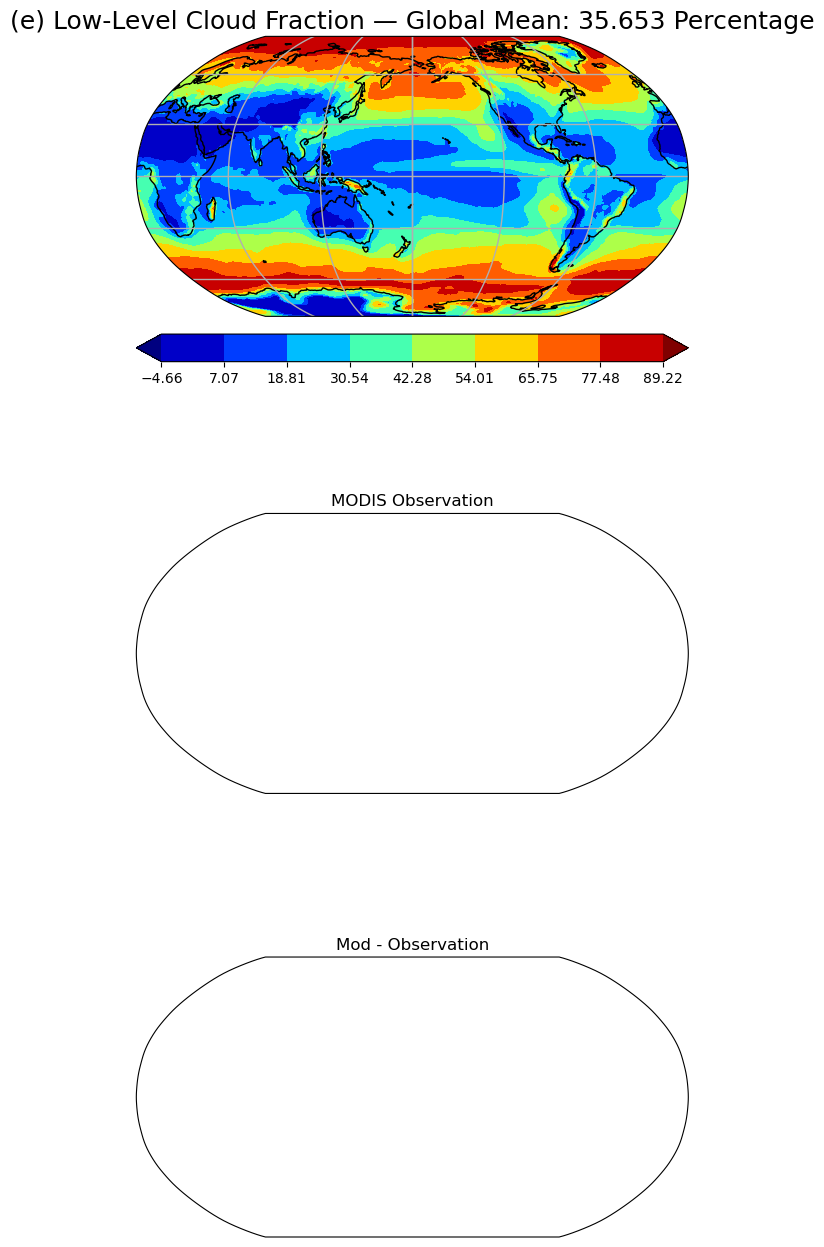

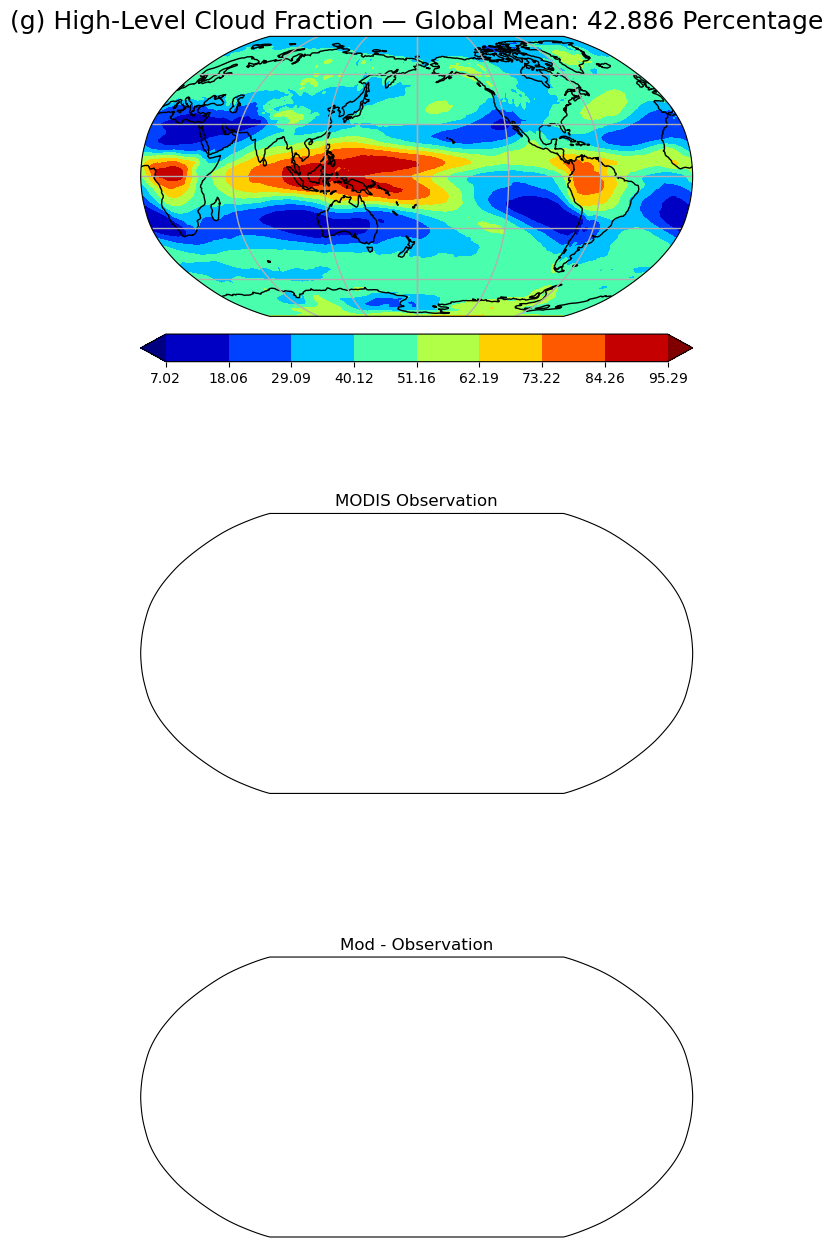

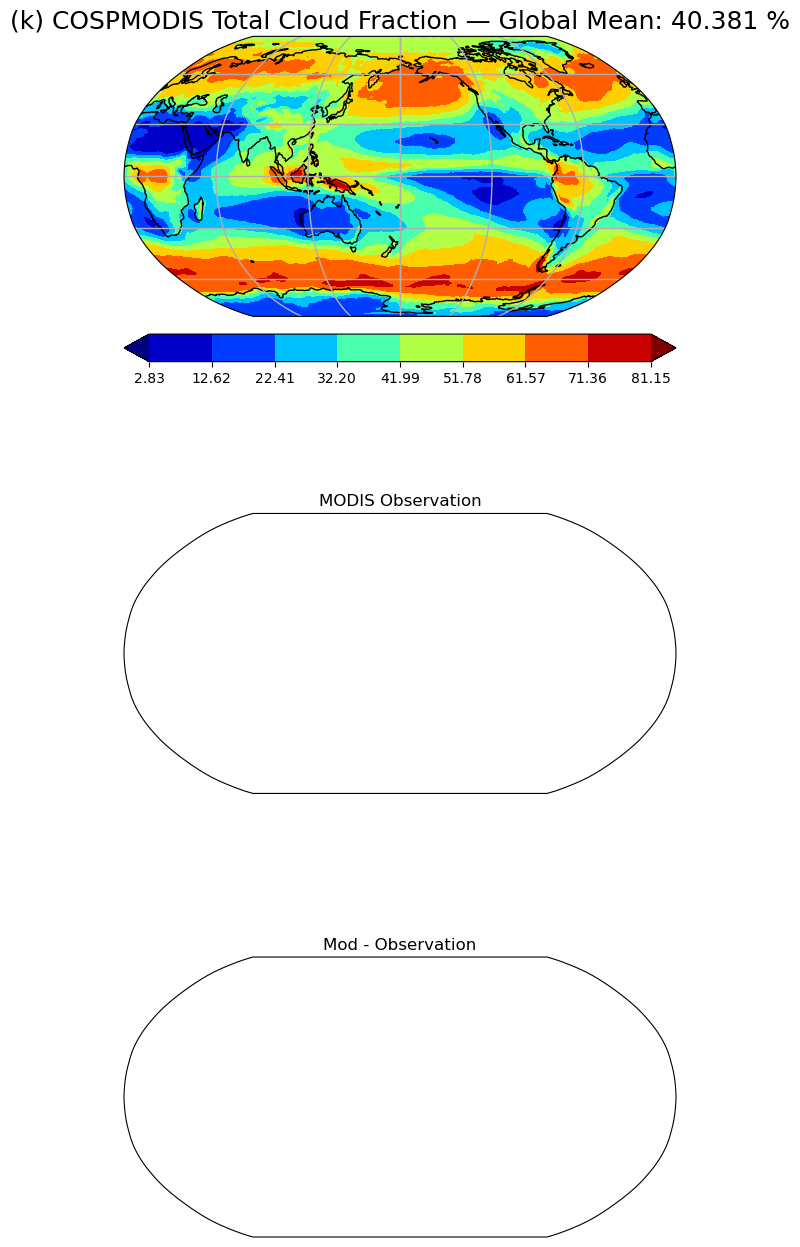

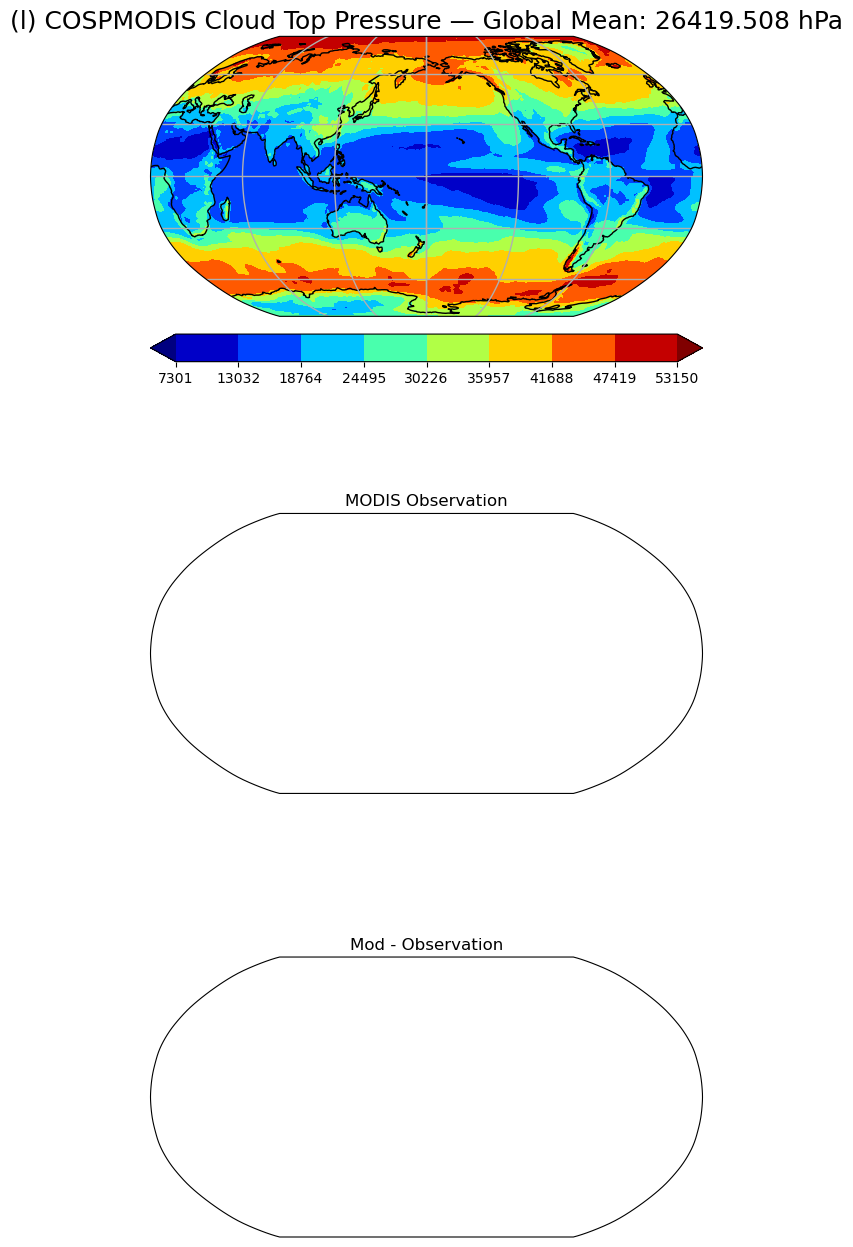

In [12]:
# Ensure you're using an ordered list, not a set!

for n, (var, longname) in enumerate(zip(vars, longnames)):
    # Adjust figure size based on number of plots
    for group in groups:
        nvars = len(vars)
        fig = plt.figure(figsize=(6,3*4.5))
        fig.subplots_adjust(top=0.96, bottom=0.04, left=0.05, right=0.97, hspace=0.25, wspace=0.02)
    
        ds = group.ds[0]
        vdata = ds[var]
        gbl_mean_time = cal_gbl_mean(ds, var)
        gbl_mean = gbl_mean_time.mean(dim=['time'])
        group.add_metric(longname, ("mean", float(gbl_mean)))

        v2d = vdata.mean(dim='time')
        ax11 = plt.subplot(3, 1, 1, projection=cartopy.crs.Robinson(central_longitude=-180) )
        ax11.set_facecolor('xkcd:gray')
        projection = cartopy.crs.PlateCarree()
        vmin = np.nanmin(v2d.values)
        vmax = np.nanmax(v2d.values)
        levels = np.linspace(vmin, vmax, 9)
        im11 = ax11.contourf(ds['lon'], ds['lat'], v2d.values, cmap= 'jet', levels=levels,
                     vmin=vmin, vmax=vmax, transform=projection,extend='both')

        ax11.gridlines(linewidth=1.0)
        ax11.set_title(f"({chr(97 + n)}) {longname} — Global Mean: {float(gbl_mean):.3f} {vdata.units}", fontsize=18)
        ax11.set_global()
        ax11.coastlines()
        plt.colorbar(im11, ax=ax11, orientation='horizontal', pad=0.05)

        # add observations
        ax11 = plt.subplot(3, 1, 2, projection=cartopy.crs.Robinson(central_longitude=-180) )
        ax11.set_title(f"MODIS Observation")
        # add mod-observation differences
        ax11 = plt.subplot(3, 1, 3, projection=cartopy.crs.Robinson(central_longitude=-180) )
        ax11.set_title(f"Mod - Observation")
    plt.show()

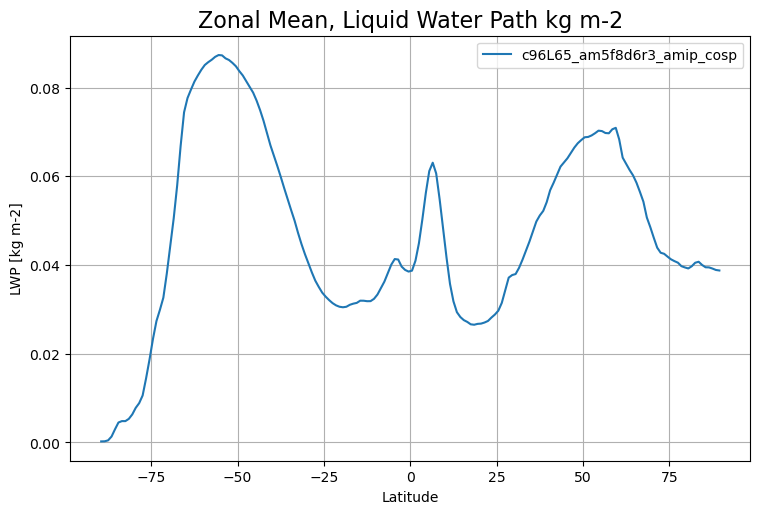

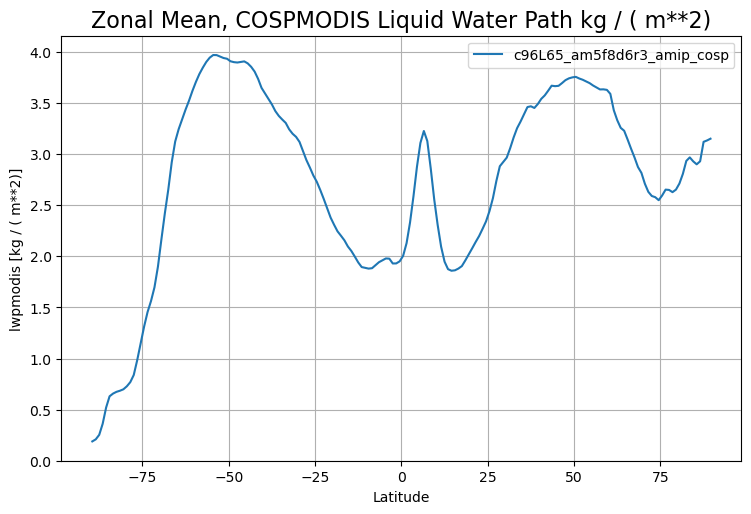

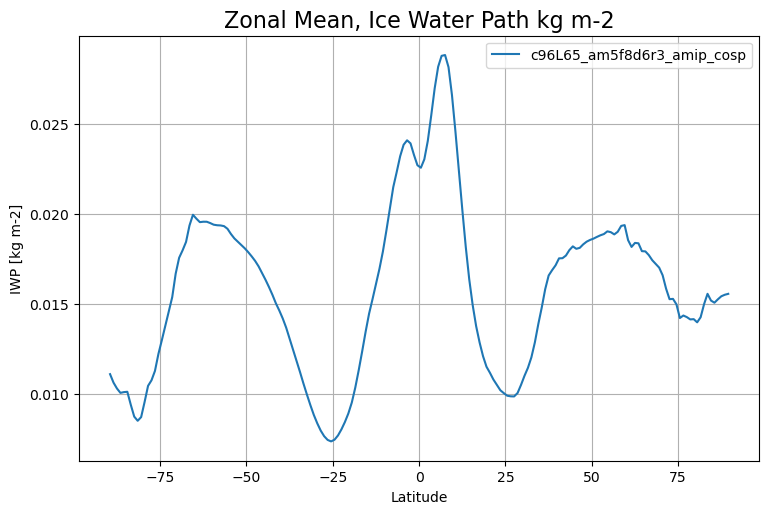

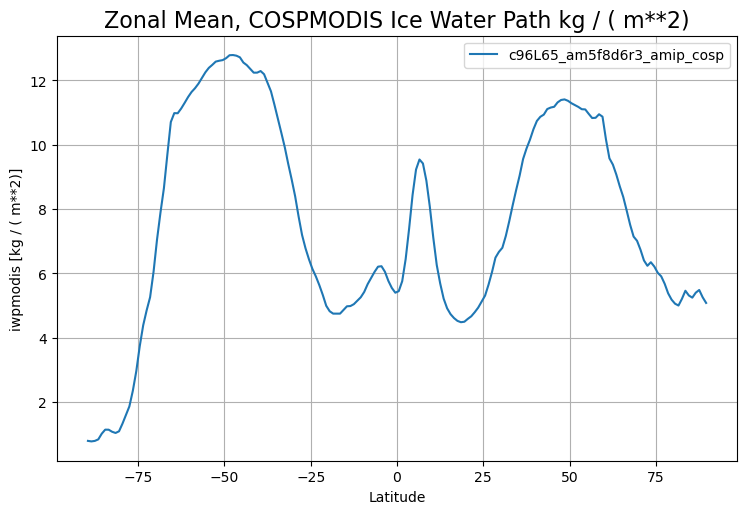

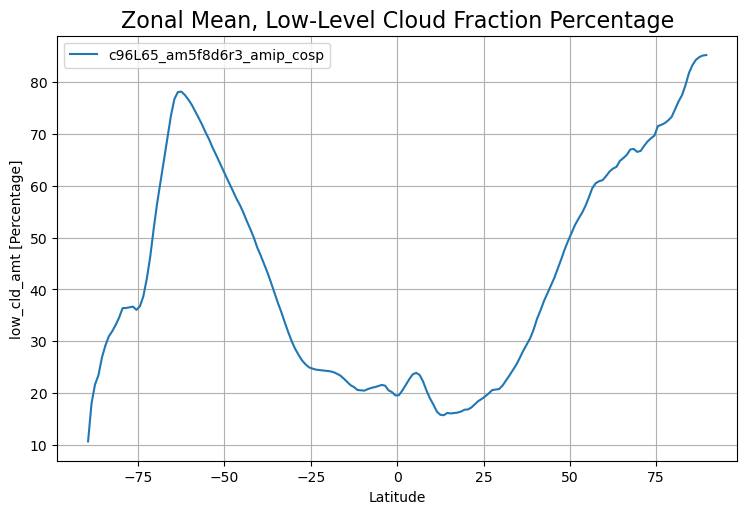

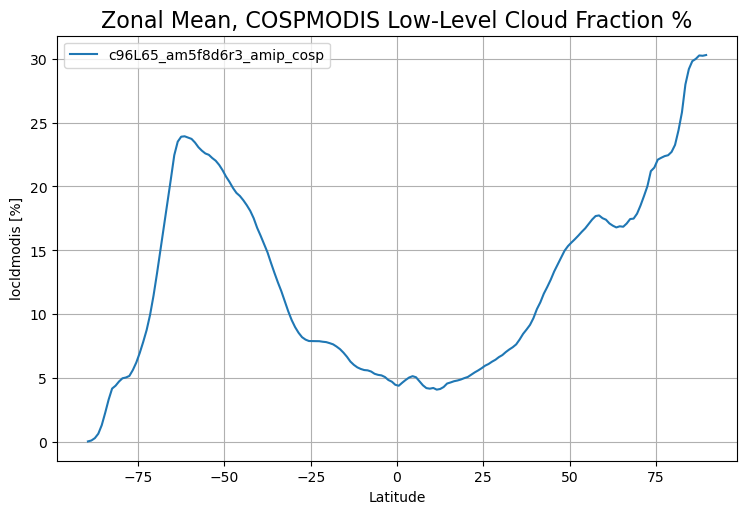

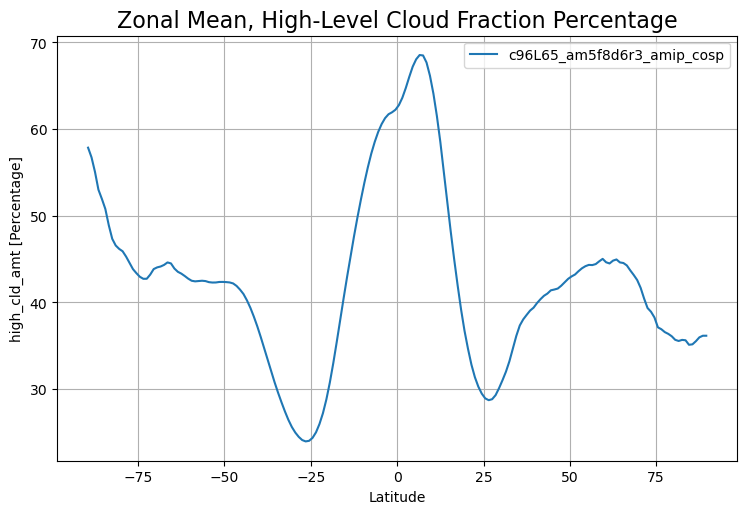

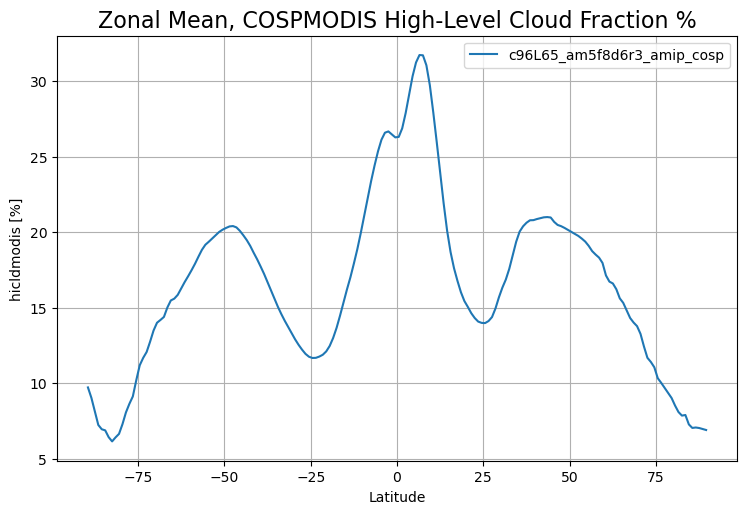

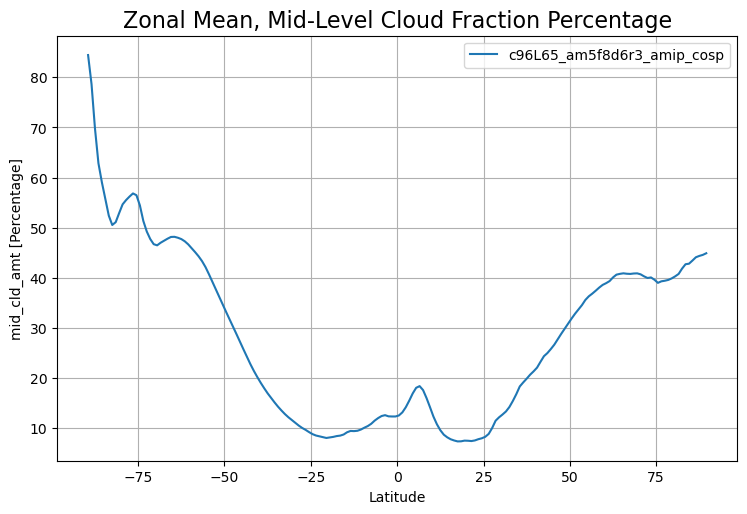

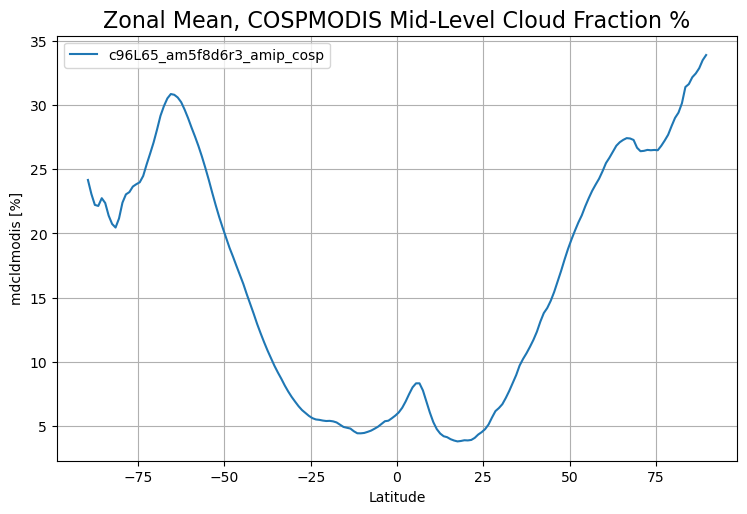

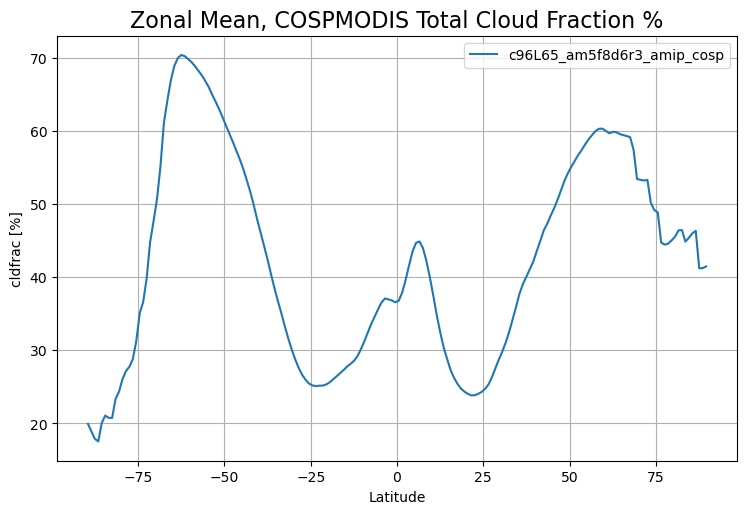

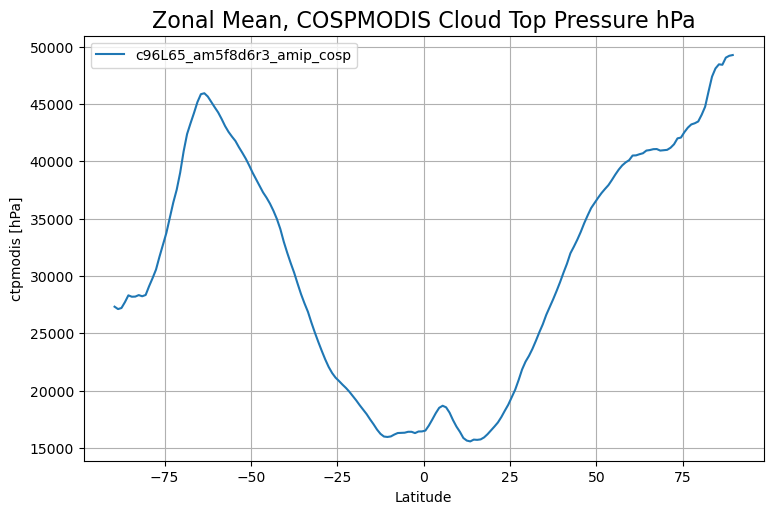

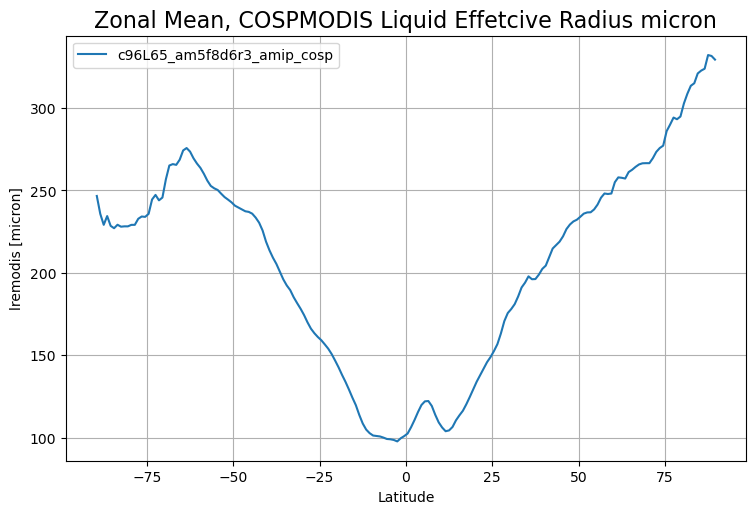

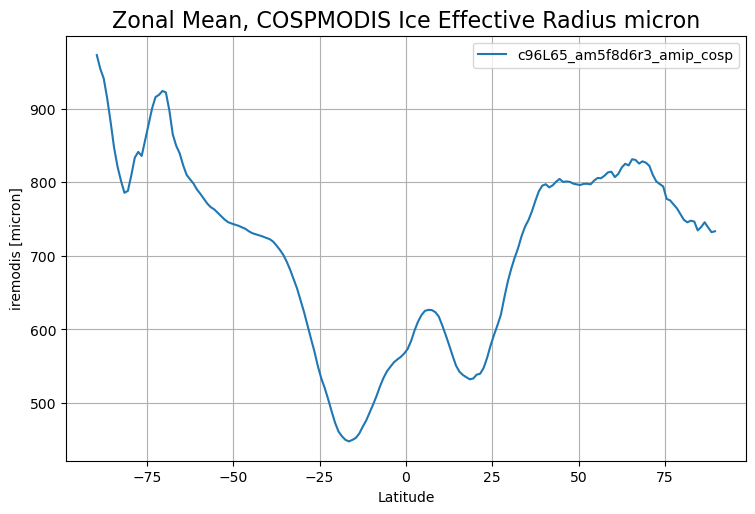

In [13]:
for var, longname in zip(vars, longnames):
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)

    for group in groups:
        ds = group.ds[0]
        ax.plot(ds['lat'], ds[var].mean(dim='time').mean(dim='lon'), label=ds.title)
        
    ax.set_title(f"Zonal Mean, {longname} {groups[0].ds[0][var].units}", fontsize=16)
    ax.set_xlabel("Latitude")
    ax.set_ylabel(f"{var} [{groups[0].ds[0][var].units}]")
    ax.legend()
    ax.grid(True)
    plt.show()



In [14]:
diag.write_metrics()

{
  "DIMENSIONS": {
    "json_structure": [
      "region",
      "model",
      "metric"
    ]
  },
  "RESULTS": {
    "Global": {
      "c96L65_am5f8d6r3_amip_cosp": {
        "Liquid Water Path": {
          "seasonal std": 0.0011142467749869441,
          "mean": 0.048249119289087004
        },
        "COSPMODIS Liquid Water Path": {
          "seasonal std": 0.07284692157399547,
          "mean": 2.8435545434123224
        },
        "Ice Water Path": {
          "seasonal std": 0.000522593507087711,
          "mean": 0.016257416777231984
        },
        "COSPMODIS Ice Water Path": {
          "seasonal std": 0.15870729697517286,
          "mean": 8.064627774079376
        },
        "Low-Level Cloud Fraction": {
          "seasonal std": 1.5927924545764764,
          "mean": 35.65264031026373
        },
        "COSPMODIS Low-Level Cloud Fraction": {
          "seasonal std": 0.5066934931388651,
          "mean": 10.54043000878873
        },
        "High-Level Cloud Fraction